# Train Mountain Car

[OpenAI Gym](http://gym.openai.com) has been designed in such a way that all environments provide the same API - i.e. the same methods `reset`, `step` and `render`, and the same abstractions of **action space** and **observation space**. Thus is should be possible to adapt the same reinforcement learning algorithms to different environments with minimal code changes.

## A Mountain Car Environment

[Mountain Car environment](https://gym.openai.com/envs/MountainCar-v0/) contains a car stuck in a valley:

<img src="images/mountaincar.png" width="300"/>

The goal is to get out of the valley and capture the flag, by doing at each step one of the following actions:

| Value | Meaning |
|---|---|
| 0 | Accelerate to the left |
| 1 | Do not accelerate |
| 2 | Accelerate to the right |

The main trick of this problem is, however, that the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

Observation space consists of just two values:

| Num | Observation  | Min | Max |
|-----|--------------|-----|-----|
|  0  | Car Position | -1.2| 0.6 |
|  1  | Car Velocity | -0.07 | 0.07 |

Reward system for the mountain car is rather tricky:

 * Reward of 0 is awarded if the agent reached the flag (position = 0.5) on top of the mountain.
 * Reward of -1 is awarded if the position of the agent is less than 0.5.

Episode terminates if the car position is more than 0.5, or episode length is greater than 200.
## Instructions

Adapt our reinforcement learning algorithm to solve the mountain car problem. Start with existing [notebook.ipynb](notebook.ipynb) code, substitute new environment, change state discretization functions, and try to make existing algorithm to train with minimal code modifications. Optimize the result by adjusting hyperparameters.

> **Note**: Hyperparameters adjustment is likely to be needed to make algorithm converge.
## Rubric

| Criteria | Exemplary | Adequate | Needs Improvement |
| -------- | --------- | -------- | ----------------- |
|          | Q-Learning algorithm is successfully adapted from CartPole example, with minimal code modifications, which is able to solve the problem of capturing the flag under 200 steps. | A new Q-Learning algorithm has been adopted from the Internet, but is well-documented; or existing algorithm adopted, but does not reach desired results | Student was not able to successfully adopt any algorithm, but has mede substantial steps towards solution (implemented state discretization, Q-Table data structure, etc.) |

## CartPole Skating

> **Problem**: If Peter wants to escape from the wolf, he needs to be able to move faster than him. We will see how Peter can learn to skate, in particular, to keep balance, using Q-Learning.

First, let's install the gym and import required libraries:

In [1]:
# Installing dependencies

!apt-get -qq install -y tensorflow-gpu

E: Unable to locate package tensorflow-gpu


In [2]:
!pip install tensorflow

In [3]:
!pip install gym-anytrading

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 4.1 MB/s eta 0:00:00


In [4]:
!pip install gym

In [5]:
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 21.1 MB/s eta 0:00:00


In [6]:
# Importing dependencies

# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [7]:
#code block 1
import sys
#!{sys.executable} -m pip install gymnasium[classic-control]

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create a cartpole environment

In [8]:
#code block 2
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
1


To see how the environment works, let's run a short simulation for 100 steps.

In [9]:
#code block 3
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()

for _ in range(100):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
       observation, info = env.reset()

env.close()

During simulation, we need to get observations in order to decide how to act. In fact, `step` function returns us back current observations, reward function, and the `done` flag that indicates whether it makes sense to continue the simulation or not:

In [10]:
#code block 4
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()
terminated = False
truncated = False
while not terminated and not truncated:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    print(f"{observation} -> {reward}")


env.close()

[-0.00982755 -0.18817638 -0.01716333  0.2883152 ] -> 1.0
[-0.01359108 -0.38304943 -0.01139703  0.57553595] -> 1.0
[-2.1252070e-02 -5.7800978e-01  1.1369342e-04  8.6460680e-01] -> 1.0
[-0.03281226 -0.38288936  0.01740583  0.5719596 ] -> 1.0
[-0.04047005 -0.18801576  0.02884502  0.28481054] -> 1.0
[-0.04423037 -0.38353696  0.03454123  0.5864496 ] -> 1.0
[-0.05190111 -0.1889154   0.04627023  0.3048445 ] -> 1.0
[-0.05567941  0.00551767  0.05236712  0.02710564] -> 1.0
[-0.05556906 -0.19031464  0.05290923  0.3358403 ] -> 1.0
[-0.05937535  0.00401599  0.05962604  0.06030035] -> 1.0
[-0.05929504  0.19823459  0.06083204 -0.21299016] -> 1.0
[-0.05533034  0.00229805  0.05657224  0.09824461] -> 1.0
[-0.05528438 -0.19358715  0.05853713  0.40822572] -> 1.0
[-0.05915612 -0.38948813  0.06670164  0.71877396] -> 1.0
[-0.06694589 -0.5854665   0.08107712  1.0316836 ] -> 1.0
[-0.07865522 -0.39151123  0.1017108   0.76551694] -> 1.0
[-0.08648545 -0.58787566  0.11702114  1.0883927 ] -> 1.0
[-0.09824295 -0.394

We can get min and max value of those numbers:

In [11]:
#code block
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


## State Discretization

In [12]:
#code block 6
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(int))

Let's also explore other discretization method using bins:

In [13]:
#code block 7
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Let's now run a short simulation and observe those discrete environment values.

In [14]:
#code block 8
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()
terminated = False
truncated  = False
while not terminated and not truncated:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    print(discretize(observation))

env.close()

(0, 0, 0, -2)
(0, 0, 0, 0)
(0, 0, 0, -2)
(0, 0, -1, 0)
(0, 0, -1, 3)
(0, 0, 0, 0)
(0, 0, 0, 3)
(0, 0, 0, 0)
(0, 0, 0, 3)
(0, -1, 0, 6)
(0, 0, 2, 3)
(0, -1, 2, 6)
(0, -2, 3, 9)
(0, -1, 5, 6)
(0, 0, 7, 3)
(0, 0, 7, 0)
(0, 0, 7, 4)
(0, -1, 8, 7)
(0, -2, 10, 10)
(0, -1, 12, 7)
(0, -2, 13, 11)
(0, -1, 16, 8)
(0, -2, 17, 12)
(0, -3, 20, 15)
(0, -2, 23, 13)


## Q-Table Structure

In [15]:
#code block 9
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

## Let's Start Q-Learning!

In [16]:
#code block 10
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90


In [18]:
#code block 11

env = gym.make("CartPole-v1", render_mode = "human")
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(300):
    observation, info = env.reset()
    terminated = False
    truncated = False
    cum_reward=0

    # == do the simulation ==
    while not terminated and not truncated:
        s = discretize(observation)
        if random.random()<epsilon:
        # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
        # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        observation, reward, terminated, truncated, info = env.step(a)
        cum_reward+=reward
        ns = discretize(observation)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (reward + gamma * max(qvalues(ns)))


    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%100==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]


0: 20.0, alpha=0.3, epsilon=0.9
100: 45.77, alpha=0.3, epsilon=0.9
200: 57.46, alpha=0.3, epsilon=0.9


## Plotting Training Progress

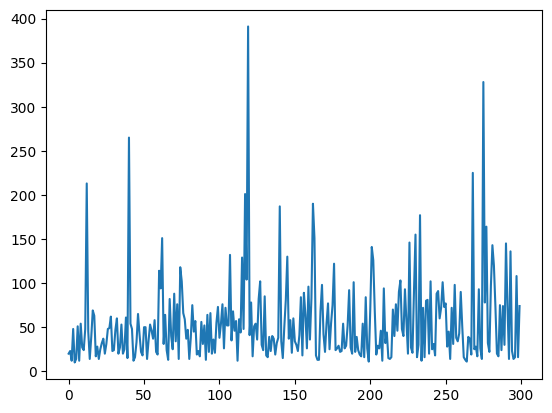

In [19]:
plt.plot(rewards)

From this graph, it is not possible to tell anything, because due to the nature of stochastic training process the length of training sessions varies greatly. To make more sense of this graph, we can calculate **running average** over series of experiments, let's say 100. This can be done conveniently using `np.convolve`:

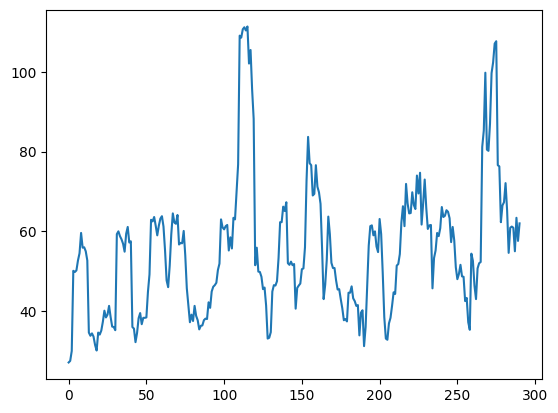

In [20]:
#code block 12
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,10))


## Varying Hyperparameters and Seeing the Result in Action

Now it would be interesting to actually see how the trained model behaves. Let's run the simulation, and we will be following the same action selection strategy as during training: sampling according to the probability distribution in Q-Table:

In [21]:
# code block 13
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()
terminated = False
truncated = False
while not terminated and not truncated:
    s = discretize(observation)
    v = probs(np.array(qvalues(s)))
    a = random.choices(actions,weights=v)[0]
    observation, reward, terminated, truncated, info = env.step(a)

env.close()


## Saving result to an animated GIF

If you want to impress your friends, you may want to send them the animated GIF picture of the balancing pole. To do this, we can invoke `env.render` to produce an image frame, and then save those to animated GIF using PIL library:

In [30]:
!pip install imageio

In [31]:
import numpy as np
import gym
from PIL import Image
import imageio

# Your environment setup code here
# ...

obs = env.reset()
done = False
i = 0
ims = []

while not done:
    s = discretize(obs)
    img = env.render(mode='rgb_array')
    ims.append(Image.fromarray(img))
    v = probs(np.array([Qbest.get((s, a), 0) for a in actions]))
    a = random.choices(actions, weights=v)[0]
    obs, _, done, _ = env.step(a)
    i += 1

env.close()

# Saving the images as a GIF using imageio
imageio.mimsave('images/cartpole-balance.gif', [np.array(im) for im in ims], duration=0.2)

print(i)


error: ignored

more practices

In [ ]:
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()